# How Elon Musk's tweets affect stock prices?


# Application setup

First of all, let's setup authentication to Twitter API.


In [8]:
import numpy
import tweepy
import pandas
import SECRETS
import re
import matplotlib.pyplot as plt

# Authenticate to Twitter
auth = tweepy.OAuthHandler(SECRETS.API_KEY, SECRETS.API_SECRET_KEY)
auth.set_access_token(SECRETS.ACCESS_TOKEN, SECRETS.ACCESS_SECRET_TOKEN)

api = tweepy.API(auth)

try:
    api.verify_credentials()
    print('Authentication OK')
except:
    print('Error during authentication')


Authentication OK



Everything seems fine, we can proceed to download data.

5 latest tweets:


In [9]:

musk_tweets = api.user_timeline(screen_name='elonmusk',
                                count=5,
                                tweet_mode='extended'
                                )

for tweet in musk_tweets:
     print('------------')
     print("ID: {}".format(tweet.id))
     print(tweet.created_at)
     print(tweet.full_text)


------------
ID: 1387140919145766912
2021-04-27 20:25:41
@PPathole Yup
------------
ID: 1387140695387951105
2021-04-27 20:24:48
@garyblack00 @CGrantWSJ @WSJ I find it more helpful to read/follow individual journalists, rather than publications. 

Any given publication is going to have wide range of views, albeit vast majority of stories about any subject are negative, perhaps reflecting innate human biases.

Citizen journalism FTW!
------------
ID: 1386841861323698177
2021-04-27 00:37:20
@kchangnyt https://t.co/eLvYOnn6zT
------------
ID: 1386836238771105793
2021-04-27 00:15:00
Starship SN15 static fire completed, preparing for flight later this week
------------
ID: 1386835900169129984
2021-04-27 00:13:39
@jeff_foust True 🤣🤣



# Downloading tweets

It is worth mentioning here that the maximum allowed .user_timeline(count=) is 200.


In [10]:

downloaded_tweets = []
last_id = musk_tweets[-1].id

while True:
    musk_tweets = api.user_timeline(screen_name='elonmusk',
                               count=200,
                               include_rts = False,
                               max_id = last_id - 1,
                               tweet_mode = 'extended'
                               )
    downloaded_tweets.extend(musk_tweets)
    if len(musk_tweets) == 0:
        break
    last_id = musk_tweets[-1].id
    downloaded_tweets.extend(musk_tweets)
    print('N of tweets downloaded till now {}'.format(len(downloaded_tweets)))

print(len(downloaded_tweets))


N of tweets downloaded till now 376
N of tweets downloaded till now 764
N of tweets downloaded till now 1142
N of tweets downloaded till now 1520
N of tweets downloaded till now 1914
N of tweets downloaded till now 2274
N of tweets downloaded till now 2624
N of tweets downloaded till now 3014
N of tweets downloaded till now 3390
N of tweets downloaded till now 3766
N of tweets downloaded till now 4152
N of tweets downloaded till now 4504
N of tweets downloaded till now 4886
N of tweets downloaded till now 5264
N of tweets downloaded till now 5642
5642



# Analysing data. First conclusions


In [11]:

words_in_tweets = {}

for tweet in downloaded_tweets:

    # using regular expression to be exclude all "@#!.?"
    t_words = re.findall(r'\w+', tweet.full_text)

    # adding words counting
    for word in t_words:
        if word in words_in_tweets:
            words_in_tweets[word] += 1
        else:
            words_in_tweets[word] = 1

words_to_work_with = words_in_tweets.copy()



We have dictionary {'word' : times_used} <br/>
Let's plot some words


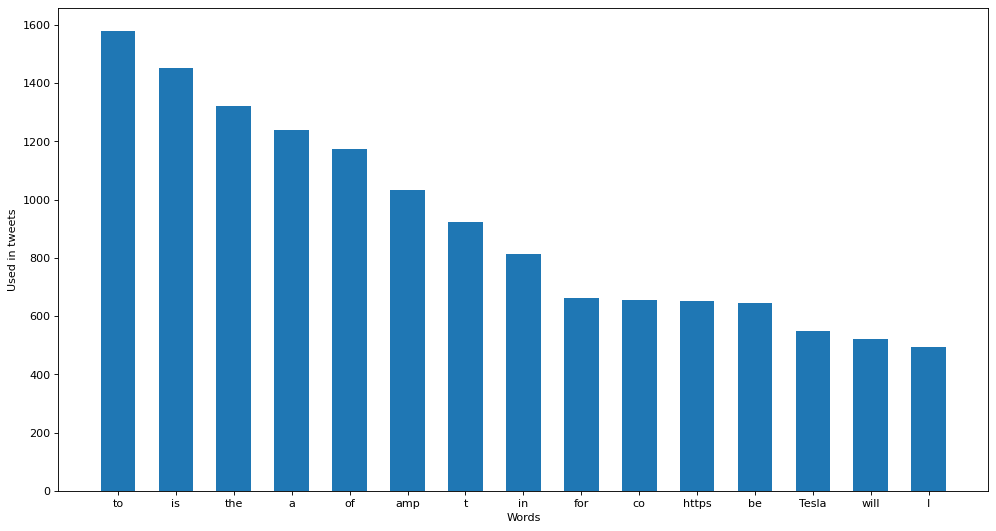

In [12]:

# we don't want to print all words yet, so let's have a look at 30 of them first
df = pandas.DataFrame(words_in_tweets.items(), columns=['word', 'used'])
df.sort_values('used',ascending=False, inplace=True)


fig = plt.figure(figsize=(15, 8), dpi=80)
ax = fig.add_subplot(111)
ax.bar('word', 'used', data=df.iloc[:15], width=0.6)
ax.set_ylabel('Used in tweets')
ax.set_xlabel('Words')
plt.show()



# Improving data quality

 We need to improve quality of our data. Let's delete some unimportant words like "the" "a" "is" etc,
 then print once again <br/>

1) It is also a good idea to save words_in_tweets to pandas.dataFrame.<br/>
2) We need to use the field *.created_at* in every tweet we are interested in (*downloaded_tweets*).


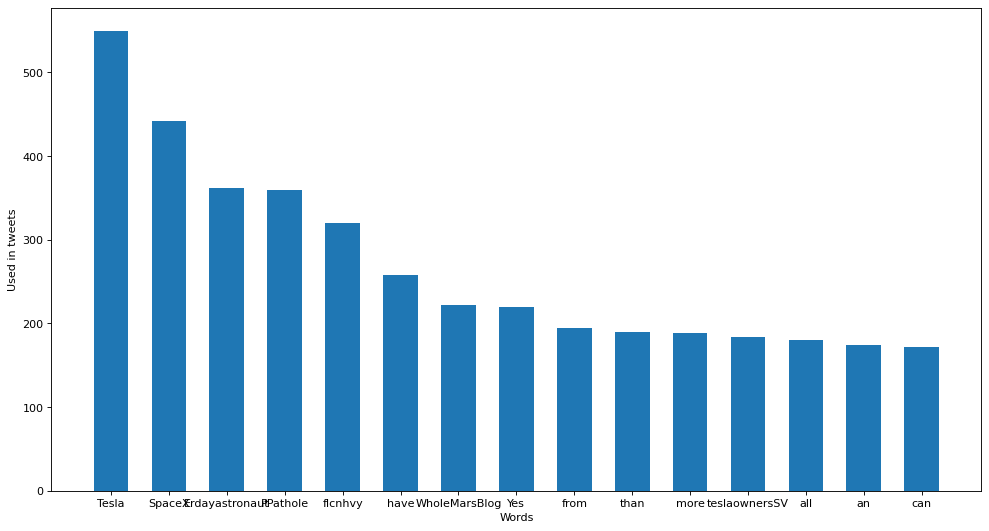

In [13]:

unimportant_words = ['the' ,'a', 'to', 'is', 't', 'of',
                     'be', 'will', 'that', 'this', 'https',
                     'co', 'on', 'we', 'with', 'so', 'for',
                     'at', 'but', 's', 'you', 'was', 'in',
                     'it', 'I', 'or', 'year', 'as', 'are',
                     'no', 'not', 'with', 'This', 'It', 'much',
                     'We', 'do', 'by', 'just', 'The', 'amp'
                     ]
for word in unimportant_words:
    words_to_work_with.pop(word, None)

df = pandas.DataFrame(words_to_work_with.items(), columns=['word', 'used'])
df.sort_values('used',ascending=False, inplace=True)


fig = plt.figure(figsize=(15, 8), dpi=80)
ax = fig.add_subplot(111)
ax.bar('word', 'used', data=df.iloc[:15], width=0.6)
ax.set_ylabel('Used in tweets')
ax.set_xlabel('Words')
plt.show()


In [14]:

# saving our dictionary to DataFrame
words_in_tweets_df = pandas.DataFrame(words_in_tweets.items(), columns=['word', 'used'])

print(words_in_tweets_df.head(15))

# saving downloaded_tweets into a pandas.DataFrame
# firstly, we need to create list  which will help us putting interesting data in df

temp_list_of_dicts = []
for tweet in downloaded_tweets:
    temp_list_of_dicts.append({'id': tweet.id,
                               'text': tweet.full_text,
                               'date': tweet.created_at})

# FILTERING DATA
downloaded_tweets_df = pandas.DataFrame(temp_list_of_dicts)
downloaded_tweets_df['text'] = downloaded_tweets_df['text'].str.lower()

df_tesla_word = downloaded_tweets_df[downloaded_tweets_df['text'].str.contains('tesla', na=False)]

# we have tweets with words tesla or spacex
print(df_tesla_word.shape)


         word  used
0   kchangnyt     2
1         Can    22
2           t   922
3         get    96
4          it   480
5          up   104
6          to  1580
7       orbit    58
8         lol     6
9    heydave7    16
10      Seems    12
11      quite    36
12     likely    40
13         at   328
14      least    40
(994, 3)



# Downloading historical data of tesla stock prices
Let's check the oldest tweet and download stock data from this day.


In [15]:

# extracting date to string
oldest_tweet_about_tesla_date = str(df_tesla_word.date.iloc[-1])

oldest_tweet_about_tesla_date = oldest_tweet_about_tesla_date.split(' ')

oldest_tweet_about_tesla_date = oldest_tweet_about_tesla_date[0]

oldest_tweet_about_tesla_date = oldest_tweet_about_tesla_date.split('-')

# YEAR MONTH DAY
date_tesla = [int(a) for a in oldest_tweet_about_tesla_date]


In [16]:
# importing important libraries
from datetime import datetime
import yfinance as yahoofinance

In [17]:

# downloading dataframe from Yahoo Finance
start_date = datetime(date_tesla[0], date_tesla[1], date_tesla[2])
end_date = datetime.now()
tesla_stock_prices_data = yahoofinance.download('TSLA', start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed



# Adjusting and merging Dataframes


In [18]:

temp_DF = df_tesla_word.copy()
temp_DF.reset_index(inplace=True)
tweets_dates_list = []

temp_DF = temp_DF.drop(columns=['index', 'id', 'text'])
for row in temp_DF.date:
    tweets_dates_list.append(str(row).split(' ')[0])

# adjusting dataframe and cleaning data
tweets_dates_DF = pandas.DataFrame(data=tweets_dates_list)
tweets_dates_DF.drop_duplicates(inplace=True)
tweets_dates_DF =  tweets_dates_DF[::-1]
tweets_dates_DF.reset_index(inplace=True)
tweets_dates_DF = tweets_dates_DF.drop(columns=['index'])
tweets_dates_DF.columns = ['Date']

prices_data = tesla_stock_prices_data.copy()
prices_data.reset_index(inplace=True)
# changing TimeStamp to str (because tweets_dates_DF.Date is str)
prices_data['Date']= prices_data['Date'].astype(str)

# merging data to print relevant markers in specific dates, dropping useless columns
inner_merged = pandas.merge(tweets_dates_DF, prices_data)
inner_merged = inner_merged.drop(columns=['Open', 'Low', 'Close',
                                          'Adj Close', 'Volume'])
prices_data = prices_data.drop(columns=['Open', 'Low', 'Close',
                                          'Adj Close', 'Volume'])

print(inner_merged.head())
print(prices_data.head())


         Date        High
0  2020-06-08  190.000000
1  2020-06-10  205.496002
2  2020-06-11  203.792007
3  2020-06-15  199.768005
4  2020-06-16  202.576004
         Date        High
0  2020-06-05  177.304001
1  2020-06-08  190.000000
2  2020-06-09  190.888000
3  2020-06-10  205.496002
4  2020-06-11  203.792007



# Plotting stock prices with tweet days markers


<ipython-input-19-0e784a0f3b6c>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  stock_price.set_xticklabels(prices_data.Date)
<ipython-input-19-0e784a0f3b6c>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  musk_twitter_act = stock_fig.add_subplot(111)


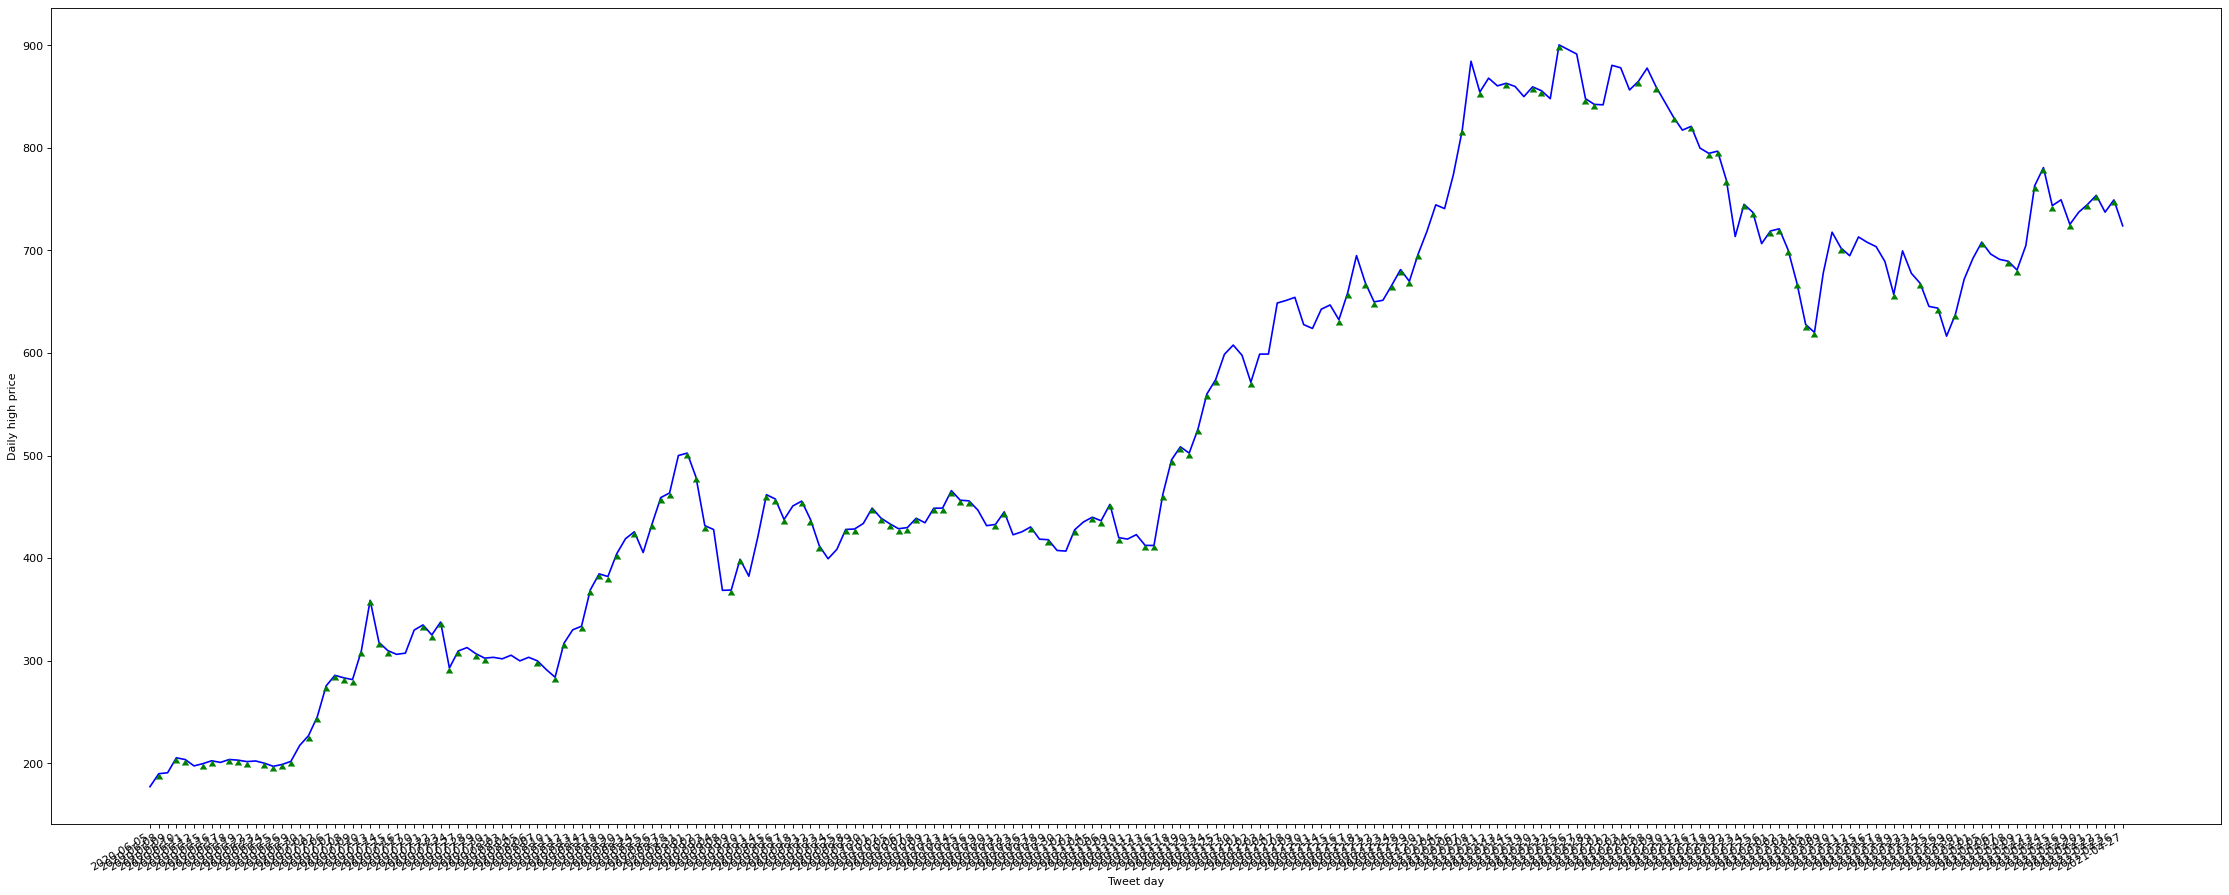

In [19]:

stock_fig = plt.figure(figsize=(35, 15), dpi=80)


stock_price = stock_fig.add_subplot(111)
stock_price.set_xticklabels(prices_data.Date)
stock_price.xaxis_date()
stock_price.plot(prices_data.Date,
                 prices_data.High,
                 color='b'
                 )
stock_price.set_ylabel('Daily high price')
stock_price.set_xlabel('Date')

musk_twitter_act = stock_fig.add_subplot(111)
musk_twitter_act.xaxis_date()
musk_twitter_act.plot(inner_merged.Date, inner_merged.High,
                      marker=6, color='g', linestyle = 'None'
                      )
musk_twitter_act.set_xlabel('Tweet day')

stock_fig.autofmt_xdate()
plt.show()



# Summarization

The graph displays the stock price of Tesla as a function of time.
The days when Elon tweeted were marked with dots.
There is an equal number of dots preceding an ascending, as there are a descending slope.
Therefore, we cannot draw the conclusion that Elon's tweets influence the stock prices.
